# Session3: Logistic Regression and Classification Metrics

## Session Overview

**Logistic Regression**: Although the name contains the word "regression," this is actually a powerful classification algorithm that forms the foundation for understanding more complex models.

### Learning Objectives

By the end of this session, you will be able to:

1. Understand the mathematical foundation of logistic regression, including the sigmoid function and log-loss cost function
2. Apply logistic regression to EEG signal classification problems
3. Evaluate classification models using multiple metrics: accuracy, precision, recall, F1-score
4. Interpret these metrics in the context of neuroscience applications
5. Build a complete classification pipeline for EEG data

In [36]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Part 1: Understanding Logistic Regression

### 1.1 The Classification Problem

In binary classification, we want to predict one of two classes (0 or 1) based on input features. For EEG applications, this could be:
- High arousal vs. Low arousal
- Eyes open vs. Eyes closed
- Epileptic seizure vs. Normal activity
- Correct response vs. Error in a cognitive task

Our input features are the EEG band powers extracted from different electrodes across the scalp. With 32 channels and 5 frequency bands (delta, theta, alpha, beta, gamma), we have 160 features for each trial.

### 1.2 The Sigmoid Function: From Linear to Probabilistic

Linear regression produces continuous outputs, but we need probabilities between 0 and 1. The **sigmoid function** (also called the logistic function) transforms any real number into this range:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

where $z = w^T x + b$ is our linear combination of features (weights $w$, bias $b$, and input features $x$).

The sigmoid has beautiful mathematical properties:
- When $z \to \infty$, $\sigma(z) \to 1$
- When $z \to -\infty$, $\sigma(z) \to 0$
- When $z = 0$, $\sigma(z) = 0.5$ (the decision boundary)
- It has a smooth S-shaped curve that represents uncertainty smoothly

Let's visualize this function:

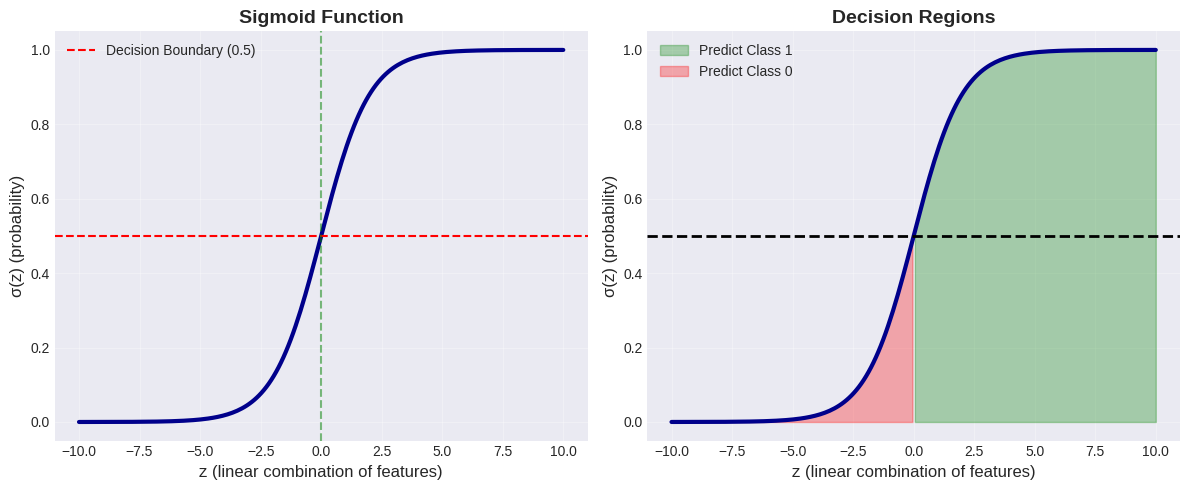

Key Points:
σ(-5) = 0.006693 → Strongly predict Class 0
σ(0) = 0.500000 → Uncertain (decision boundary)
σ(5) = 0.993307 → Strongly predict Class 1


In [35]:
def sigmoid(z):
    """
    Compute the sigmoid function.

    Parameters:
    z: array-like, input values

    Returns:
    Sigmoid transformation of z, values between 0 and 1
    """
    return 1 / (1 + np.exp(-z))

# Generate values for visualization
z_values = np.linspace(-10, 10, 200)
sigmoid_values = sigmoid(z_values)

# Create visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(z_values, sigmoid_values, linewidth=3, color='darkblue')
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Boundary (0.5)')
plt.axvline(x=0, color='green', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.xlabel('z (linear combination of features)', fontsize=12)
plt.ylabel('σ(z) (probability)', fontsize=12)
plt.title('Sigmoid Function', fontsize=14, fontweight='bold')
plt.legend()

# Show decision regions
plt.subplot(1, 2, 2)
plt.plot(z_values, sigmoid_values, linewidth=3, color='darkblue')
plt.fill_between(z_values, 0, sigmoid_values, where=(sigmoid_values >= 0.5),
                 alpha=0.3, color='green', label='Predict Class 1')
plt.fill_between(z_values, 0, sigmoid_values, where=(sigmoid_values < 0.5),
                 alpha=0.3, color='red', label='Predict Class 0')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('z (linear combination of features)', fontsize=12)
plt.ylabel('σ(z) (probability)', fontsize=12)
plt.title('Decision Regions', fontsize=14, fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

print("Key Points:")
print(f"σ(-5) = {sigmoid(-5):.6f} → Strongly predict Class 0")
print(f"σ(0) = {sigmoid(0):.6f} → Uncertain (decision boundary)")
print(f"σ(5) = {sigmoid(5):.6f} → Strongly predict Class 1")

### 1.3 The Log-Loss Cost Function

To train our logistic regression model, we need a cost function that measures how well our predictions match the true labels. We use **binary cross-entropy loss** (also called log-loss):

$$J(w, b) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]$$

where:
- $m$ is the number of training examples
- $y^{(i)}$ is the true label (0 or 1) for example $i$
- $\hat{y}^{(i)} = \sigma(w^T x^{(i)} + b)$ is our predicted probability

**Why this particular form?** This cost function has important properties:

1. **It penalizes confident wrong predictions heavily**: If $y=1$ but we predict $\hat{y} \approx 0$, the term $\log(\hat{y})$ becomes very negative (high loss).

2. **It's convex**: This guarantees that gradient descent will find the global minimum.

3. **It has a probabilistic interpretation**: It's the negative log-likelihood of the data, which connects to maximum likelihood estimation.

Let's visualize how the loss changes with predictions:

### 1.4 The Gradient

#### Computing the Gradient

The gradient tells us the direction and rate of steepest increase in our cost function. We want to go in the opposite direction (downhill) to minimize cost.

For logistic regression, the gradients are:

$$\frac{\partial J}{\partial w_j} = \frac{1}{m}\sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) \cdot x_j^{(i)}$$

$$\frac{\partial J}{\partial b} = \frac{1}{m}\sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})$$

Notice the elegant form: the gradient is proportional to the prediction error $(\hat{y} - y)$ multiplied by the feature value. Bigger errors lead to bigger updates!

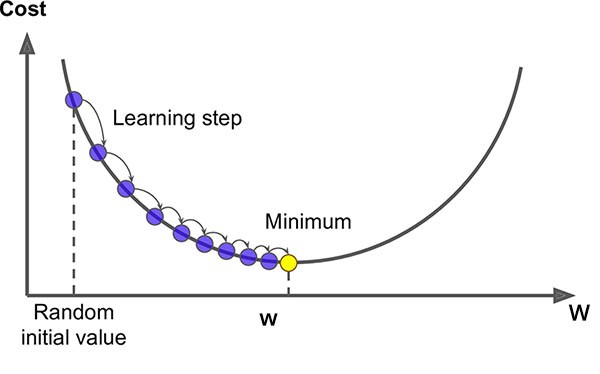

### Summary:
Gradient descent for logistic regression involves these key steps:

**1. Model Setup:** We use the sigmoid function to convert linear combinations into probabilities: $\hat{y} = \sigma(w \cdot x + b)$

**2. Measure Error:** The binary cross-entropy cost function tells us how wrong our predictions are

**3. Calculate Gradients:** We compute how the cost changes with respect to each parameter

**4. Update Parameters:** We take small steps in the direction that reduces cost: $w := w - \alpha \cdot \frac{\partial J}{\partial w}$

**5. Repeat:** We iterate this process until the cost converges to a minimum


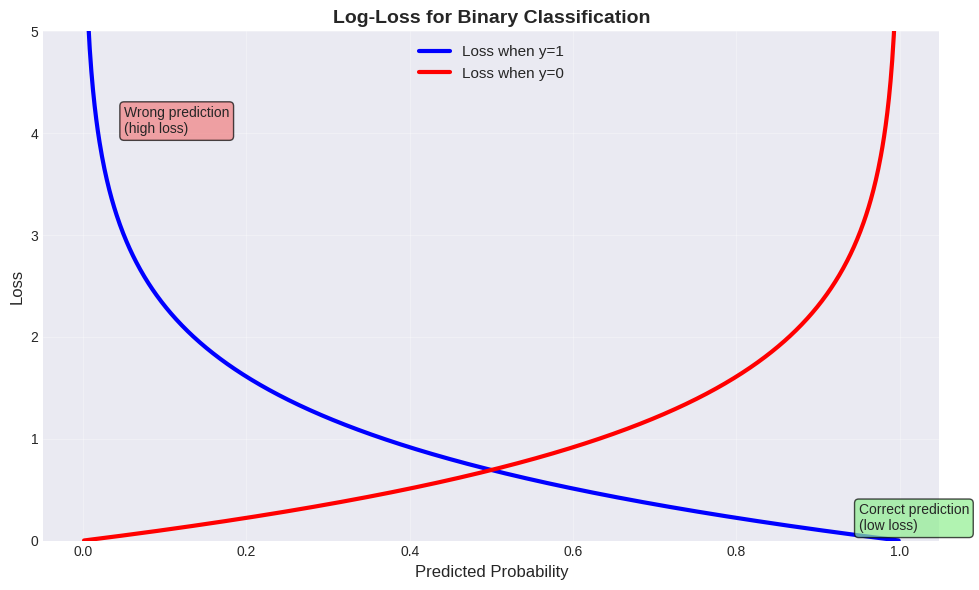

Understanding the curves:

Blue line (y=1): When the true class is 1:
  - Predicting high probability (→1) gives low loss ✓
  - Predicting low probability (→0) gives high loss ✗

Red line (y=0): When the true class is 0:
  - Predicting low probability (→0) gives low loss ✓
  - Predicting high probability (→1) gives high loss ✗


In [4]:
# Visualize log-loss for different scenarios
predicted_probs = np.linspace(0.001, 0.999, 1000)

# Loss when true label is 1
loss_when_y_1 = -np.log(predicted_probs)
# Loss when true label is 0
loss_when_y_0 = -np.log(1 - predicted_probs)

plt.figure(figsize=(10, 6))
plt.plot(predicted_probs, loss_when_y_1, label='Loss when y=1', linewidth=3, color='blue')
plt.plot(predicted_probs, loss_when_y_0, label='Loss when y=0', linewidth=3, color='red')
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Log-Loss for Binary Classification', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 5])

# Add annotations
plt.annotate('Correct prediction\n(low loss)', xy=(0.95, 0.1), fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
plt.annotate('Wrong prediction\n(high loss)', xy=(0.05, 4), fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

print("Understanding the curves:")
print("\nBlue line (y=1): When the true class is 1:")
print("  - Predicting high probability (→1) gives low loss ✓")
print("  - Predicting low probability (→0) gives high loss ✗")
print("\nRed line (y=0): When the true class is 0:")
print("  - Predicting low probability (→0) gives low loss ✓")
print("  - Predicting high probability (→1) gives high loss ✗")

## Part 2: Creating Synthetic EEG Data

### 2.1 EEG Feature Space

Before working with real data, we will create synthetic EEG features to understand the classification process clearly.

For our example, we will simulate a scenario where we want to classify mental states based on these band powers across 32 electrodes. We will create data where certain frequency bands show different patterns between the two classes.

In [15]:
def generate_synthetic_eeg_data(n_samples=500, n_channels=32, noise_level=4):
    """
    Generate synthetic EEG band power features for binary classification.

    We simulate a scenario where:
    - Class 0 (e.g., low arousal): Higher alpha power, lower beta/gamma
    - Class 1 (e.g., high arousal): Higher beta/gamma power, lower alpha

    Parameters:
    n_samples: Total number of trials to generate
    n_channels: Number of EEG channels (default 32)
    noise_level: Amount of random noise to add (0-1)

    Returns:
    X: Feature matrix (n_samples, n_channels * 5)
    y: Labels (n_samples,)
    feature_names: List of feature names
    """
    bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    n_features = n_channels * len(bands)

    # Create feature names
    feature_names = []
    for ch in range(1, n_channels + 1):
        for band in bands:
            feature_names.append(f'ch{ch}_{band}')

    # Generate labels (balanced dataset)
    y = np.random.choice([0, 1], size=n_samples)

    # Initialize feature matrix
    X = np.zeros((n_samples, n_features))

    # Generate features for each sample
    for i in range(n_samples):
        for ch in range(n_channels):
            # Base power values (all positive, as power is always positive)
            base_delta = np.random.uniform(2, 4)
            base_theta = np.random.uniform(1.5, 3)

            if y[i] == 0:  # Class 0: Low arousal state
                # Higher alpha, lower beta and gamma
                alpha_power = np.random.uniform(3, 5)
                beta_power = np.random.uniform(0.5, 1.5)
                gamma_power = np.random.uniform(0.3, 0.8)
            else:  # Class 1: High arousal state
                # Lower alpha, higher beta and gamma
                alpha_power = np.random.uniform(1, 2.5)
                beta_power = np.random.uniform(2, 4)
                gamma_power = np.random.uniform(1.5, 3)

            # Add some spatial variation (frontal channels may differ from posterior)
            spatial_factor = 1 + 0.2 * np.sin(ch / n_channels * np.pi)

            # Assign to feature matrix
            idx = ch * len(bands)
            X[i, idx] = base_delta * spatial_factor
            X[i, idx + 1] = base_theta * spatial_factor
            X[i, idx + 2] = alpha_power * spatial_factor
            X[i, idx + 3] = beta_power * spatial_factor
            X[i, idx + 4] = gamma_power * spatial_factor

    # Add noise to make the problem more realistic
    X += np.random.normal(0, noise_level, X.shape)

    # Ensure all powers remain positive
    X = np.abs(X)

    return X, y, feature_names

# Generate dataset
print("Generating synthetic EEG dataset...")
X, y, feature_names = generate_synthetic_eeg_data(n_samples=500, n_channels=32)

print(f"\nDataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]} (32 channels × 5 bands)")
print(f"Number of samples: {X.shape[0]}")
print(f"\nClass distribution:")
print(f"  Class 0 (Low arousal): {np.sum(y == 0)} samples ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"  Class 1 (High arousal): {np.sum(y == 1)} samples ({np.sum(y == 1)/len(y)*100:.1f}%)")

Generating synthetic EEG dataset...

Dataset shape: (500, 160)
Number of features: 160 (32 channels × 5 bands)
Number of samples: 500

Class distribution:
  Class 0 (Low arousal): 237 samples (47.4%)
  Class 1 (High arousal): 263 samples (52.6%)


### 2.2 Exploring the Feature Distribution

Let's visualize how our features differ between the two classes. This exploration helps us understand what the logistic regression model will learn to distinguish the classes.

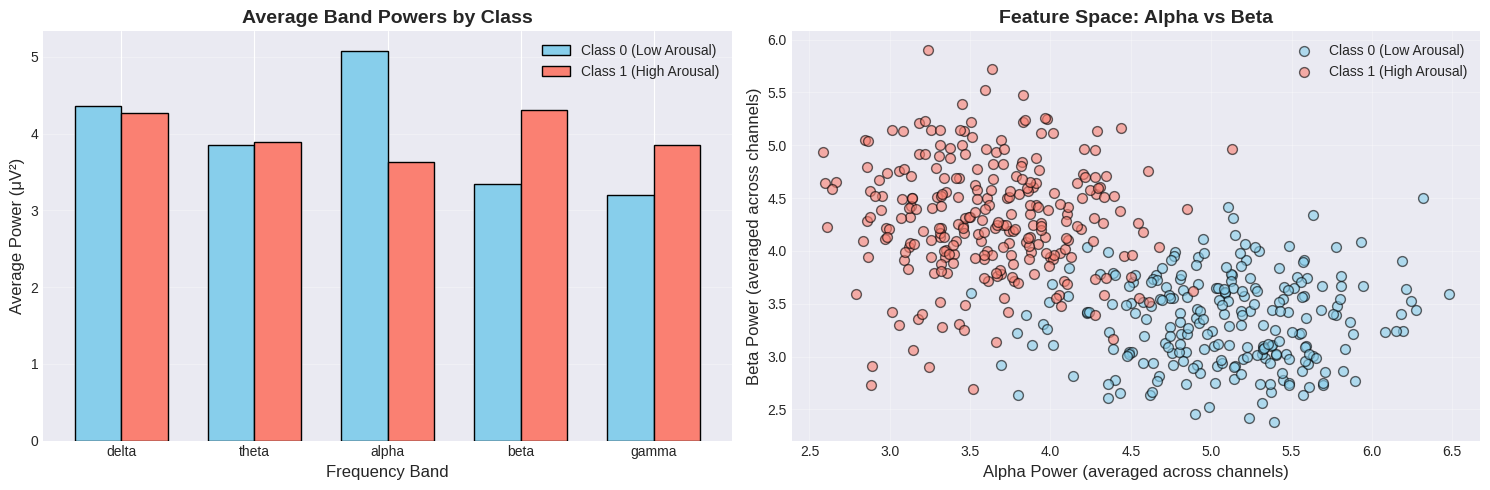


Key Observations:
  - Class 0 has higher alpha (5.08) and lower beta (3.34)
  - Class 1 has lower alpha (3.63) and higher beta (4.31)
  - This pattern is consistent with real EEG: alpha ↑ in relaxed states, beta ↑ in active states


In [16]:
# Calculate average band powers across all channels for each class
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
n_channels = 32

avg_powers_class0 = []
avg_powers_class1 = []

for band_idx, band in enumerate(bands):
    # Get all features for this band across all channels
    band_features = X[:, band_idx::5]
    # Average across channels and then across samples for each class
    avg_powers_class0.append(band_features[y == 0].mean())
    avg_powers_class1.append(band_features[y == 1].mean())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot comparing average band powers
x_pos = np.arange(len(bands))
width = 0.35

axes[0].bar(x_pos - width/2, avg_powers_class0, width, label='Class 0 (Low Arousal)',
            color='skyblue', edgecolor='black')
axes[0].bar(x_pos + width/2, avg_powers_class1, width, label='Class 1 (High Arousal)',
            color='salmon', edgecolor='black')
axes[0].set_xlabel('Frequency Band', fontsize=12)
axes[0].set_ylabel('Average Power (μV²)', fontsize=12)
axes[0].set_title('Average Band Powers by Class', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(bands)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Distribution of alpha and beta powers (most discriminative)
alpha_features = X[:, 2::5].mean(axis=1)  # Average alpha across channels
beta_features = X[:, 3::5].mean(axis=1)   # Average beta across channels

axes[1].scatter(alpha_features[y == 0], beta_features[y == 0],
               alpha=0.6, s=50, label='Class 0 (Low Arousal)', color='skyblue', edgecolor='black')
axes[1].scatter(alpha_features[y == 1], beta_features[y == 1],
               alpha=0.6, s=50, label='Class 1 (High Arousal)', color='salmon', edgecolor='black')
axes[1].set_xlabel('Alpha Power (averaged across channels)', fontsize=12)
axes[1].set_ylabel('Beta Power (averaged across channels)', fontsize=12)
axes[1].set_title('Feature Space: Alpha vs Beta', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"  - Class 0 has higher alpha ({avg_powers_class0[2]:.2f}) and lower beta ({avg_powers_class0[3]:.2f})")
print(f"  - Class 1 has lower alpha ({avg_powers_class1[2]:.2f}) and higher beta ({avg_powers_class1[3]:.2f})")
print(f"  - This pattern is consistent with real EEG: alpha ↑ in relaxed states, beta ↑ in active states")

## Part 3: Training a Logistic Regression Model

### 3.1 Data Preparation

Before training, we need to perform two critical steps:

1. **Split the data**: Separate our data into training and testing sets. We train the model on one portion and evaluate it on unseen data to assess generalization.

2. **Feature scaling**: Standardize features to have mean=0 and standard deviation=1. This is crucial for logistic regression because:
   - Features are on different scales (band powers can vary in magnitude)
   - Gradient descent converges faster with normalized features
   - The learned weights become more interpretable and comparable

In [17]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(f"  Class 0: {np.sum(y_train == 0)} samples")
print(f"  Class 1: {np.sum(y_train == 1)} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training set size: 400 samples
Testing set size: 100 samples

Training set class distribution:
  Class 0: 190 samples
  Class 1: 210 samples


### 3.2 Training the Model

Now we will train our logistic regression model. The algorithm will:

1. Initialize weights randomly
2. Compute predictions using the sigmoid function
3. Calculate the log-loss
4. Update weights using gradient descent to minimize the loss
5. Repeat until convergence

The scikit-learn implementation uses an efficient optimization algorithm that handles this process automatically.

In [21]:
# Train logistic regression model
# max_iter=1000 ensures convergence for our data
log_reg = LogisticRegression(random_state=42, max_iter=1000)

print("Training logistic regression model...")
log_reg.fit(X_train_scaled, y_train)
print("Training complete!\n")

# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Get probability predictions
y_train_pred_proba = log_reg.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Model training completed successfully!")
print(f"\nExample predictions (first 5 test samples):")
print(f"{'True Label':<12} {'Predicted':<12} {'Probability of Class 1':<25}")
print("-" * 50)
for i in range(min(5, len(y_test))):
    print(f"{y_test[i]:<12} {y_test_pred[i]:<12} {y_test_pred_proba[i]:<25.4f}")

Training logistic regression model...
Training complete!

Model training completed successfully!

Example predictions (first 5 test samples):
True Label   Predicted    Probability of Class 1   
--------------------------------------------------
1            1            0.9988                   
0            0            0.0000                   
1            1            0.9980                   
0            0            0.0008                   
0            0            0.0182                   


### 3.3 Understanding Model Coefficients

One of the advantages of logistic regression is interpretability. The learned coefficients tell us how much each feature contributes to the classification. Positive coefficients push the prediction toward Class 1, while negative coefficients push toward Class 0.

Let's examine which EEG features are most important for our classification:

Top 15 Most Important Features:
   feature  coefficient  abs_coefficient
ch12_alpha    -0.913714         0.913714
 ch2_alpha    -0.834017         0.834017
ch28_alpha    -0.703671         0.703671
 ch4_alpha    -0.674950         0.674950
  ch6_beta     0.672417         0.672417
ch19_alpha    -0.670369         0.670369
ch22_alpha    -0.661207         0.661207
ch30_alpha    -0.653922         0.653922
 ch31_beta     0.650879         0.650879
 ch9_alpha    -0.629947         0.629947
ch14_alpha    -0.621808         0.621808
 ch16_beta     0.586033         0.586033
ch25_alpha    -0.581834         0.581834
ch21_alpha    -0.580687         0.580687
 ch23_beta     0.559265         0.559265


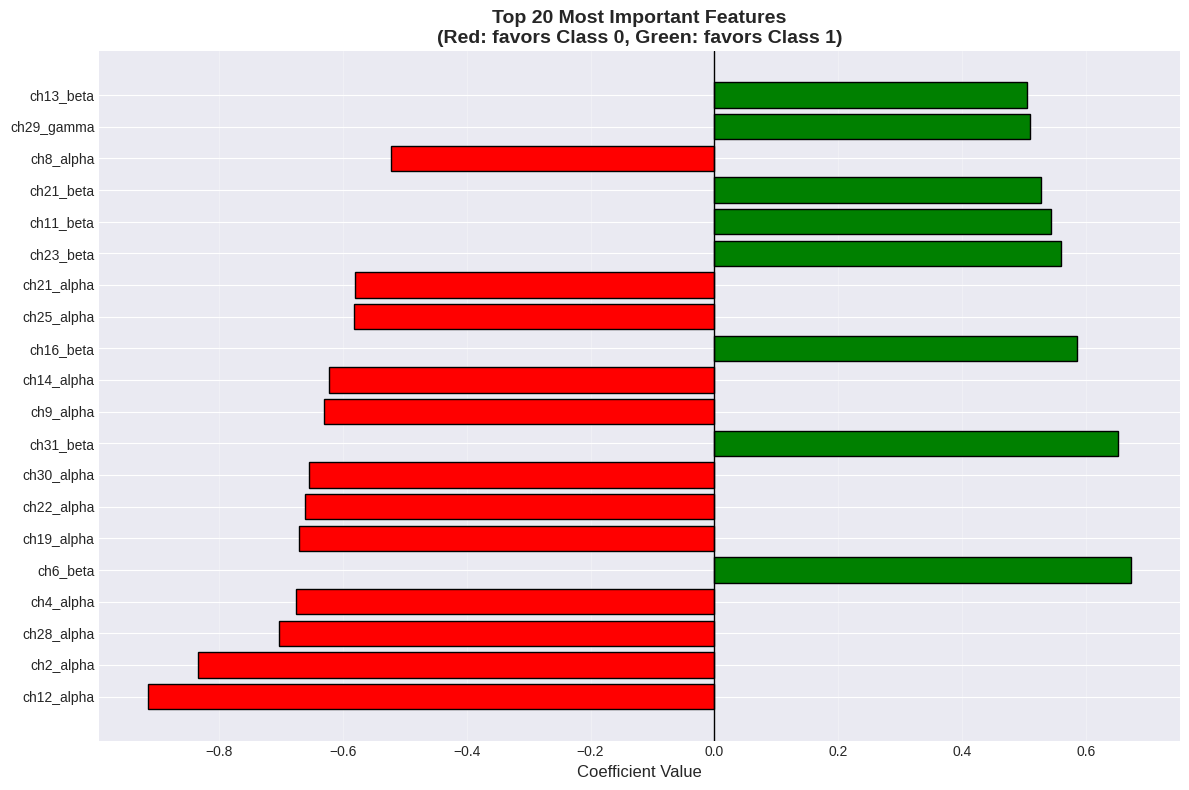



Average Coefficient Magnitude by Frequency Band:
Delta       -0.0099
Theta       -0.0323
Alpha       -0.4525
Beta         0.3116
Gamma        0.2234


In [22]:
# Extract and analyze coefficients
coefficients = log_reg.coef_[0]

# Create a DataFrame for better analysis
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# Sort by absolute value to find most important features
coef_df_sorted = coef_df.sort_values('abs_coefficient', ascending=False)

print("Top 15 Most Important Features:")
print(coef_df_sorted.head(15).to_string(index=False))

# Visualize top features
top_n = 20
top_features = coef_df_sorted.head(top_n)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
plt.barh(range(top_n), top_features['coefficient'], color=colors, edgecolor='black')
plt.yticks(range(top_n), top_features['feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title(f'Top {top_n} Most Important Features\n(Red: favors Class 0, Green: favors Class 1)',
         fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Calculate average coefficient per band
print("\n\nAverage Coefficient Magnitude by Frequency Band:")
for band_idx, band in enumerate(bands):
    band_coefs = coefficients[band_idx::5]
    avg_coef = np.mean(band_coefs)
    print(f"{band.capitalize():<10} {avg_coef:>8.4f}")

## Part 4: Classification Metrics - Evaluating Model Performance

### 4.1 The Confusion Matrix

Before diving into specific metrics, we need to understand the confusion matrix. This is a table that describes the performance of a classification model:

```
                    Predicted
                 Negative  Positive
Actual Negative     TN        FP
       Positive     FN        TP
```

Where:
- **True Positives (TP)**: Correctly predicted positive class
- **True Negatives (TN)**: Correctly predicted negative class
- **False Positives (FP)**: Incorrectly predicted positive (Type I error)
- **False Negatives (FN)**: Incorrectly predicted negative (Type II error)

All our metrics are derived from these four values.

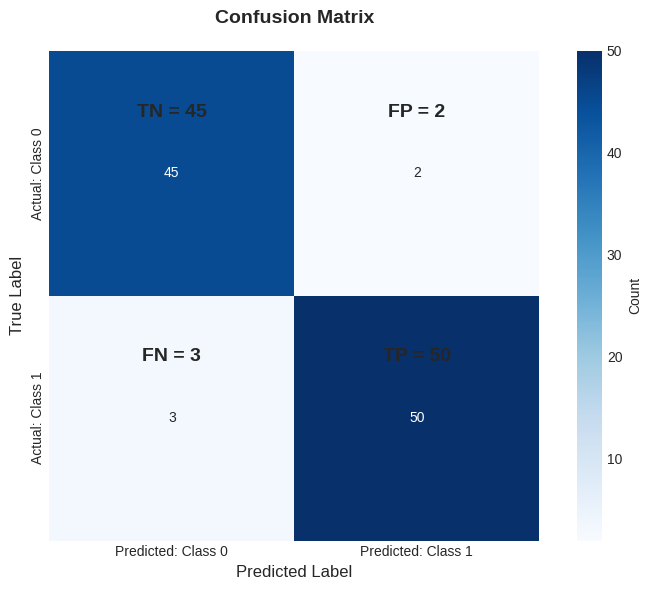


Confusion Matrix Components:
  True Negatives (TN):  45
  False Positives (FP): 2
  False Negatives (FN): 3
  True Positives (TP):  50


In [23]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Predicted: Class 0', 'Predicted: Class 1'],
            yticklabels=['Actual: Class 0', 'Actual: Class 1'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add text annotations for clarity
plt.text(0.5, 0.25, f'TN = {cm[0, 0]}', ha='center', va='center', fontsize=14, fontweight='bold')
plt.text(1.5, 0.25, f'FP = {cm[0, 1]}', ha='center', va='center', fontsize=14, fontweight='bold')
plt.text(0.5, 1.25, f'FN = {cm[1, 0]}', ha='center', va='center', fontsize=14, fontweight='bold')
plt.text(1.5, 1.25, f'TP = {cm[1, 1]}', ha='center', va='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Components:")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")

### 4.2 Accuracy

**Accuracy** is the most intuitive metric: the proportion of correct predictions among all predictions.

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

**When to use it**: Accuracy is useful when classes are balanced and all types of errors are equally important.

**When NOT to use it**: With imbalanced datasets. For example, if 95% of samples are Class 0, a model that always predicts Class 0 achieves 95% accuracy but is useless!

**In EEG context**: Accuracy is reasonable when we have balanced datasets, but in clinical applications (like seizure detection), we often care more about specific error types.

In [25]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=" * 60)
print("ACCURACY")
print("=" * 60)
print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"\nInterpretation:")
print(f"  Out of {len(y_test)} test samples, {int(test_accuracy * len(y_test))} were correctly classified.")
print(f"  The model makes correct predictions {test_accuracy*100:.1f}% of the time on unseen data.")


ACCURACY

Training Accuracy: 1.0000 (100.00%)
Testing Accuracy:  0.9500 (95.00%)

Interpretation:
  Out of 100 test samples, 95 were correctly classified.
  The model makes correct predictions 95.0% of the time on unseen data.


### 4.3 Precision

**Precision** (also called Positive Predictive Value) answers the question: "Of all samples we predicted as positive, how many were actually positive?"

$$\text{Precision} = \frac{TP}{TP + FP}$$

**When to use it**: When false positives are costly.


- Email spam detection: A false positive (marking legitimate email as spam) is annoying
- Disease diagnosis: A false positive might lead to unnecessary treatment or anxiety
- BCI applications: High precision ensures that when the system detects an intention (like "move cursor left"), it's reliable

High precision means when the model says "yes," it's usually right.

In [29]:
# Calculate precision
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

print("=" * 60)
print("PRECISION")
print("=" * 60)
print(f"\nTraining Precision: {train_precision:.4f}")
print(f"Testing Precision:  {test_precision:.4f}")

print(f"\nInterpretation:")
n_predicted_positive = np.sum(y_test_pred == 1)
n_true_positive = np.sum((y_test == 1) & (y_test_pred == 1))
print(f"  Out of {n_predicted_positive} samples predicted as Class 1 (high arousal),")
print(f"  {n_true_positive} were actually Class 1.")
print(f"  When our model predicts high arousal, it's correct {test_precision*100:.1f}% of the time.")
print(f"\n  False positive rate in predictions: {(1-test_precision)*100:.1f}%")

PRECISION

Training Precision: 1.0000
Testing Precision:  0.9615

Interpretation:
  Out of 52 samples predicted as Class 1 (high arousal),
  50 were actually Class 1.
  When our model predicts high arousal, it's correct 96.2% of the time.

  False positive rate in predictions: 3.8%


### 4.4 Recall (Sensitivity)

**Recall** (also called Sensitivity or True Positive Rate) answers: "Of all actual positive samples, how many did we correctly identify?"

$$\text{Recall} = \frac{TP}{TP + FN}$$

**When to use it**: When false negatives are costly.


- Seizure detection: Missing a seizure (false negative) could be life-threatening
- Drowsiness detection in drivers: Better to have false alarms than miss actual drowsiness
- Disease screening: Better to flag for further testing than miss a patient who needs treatment

High recall means we catch most of the positive cases, even if we have some false alarms.

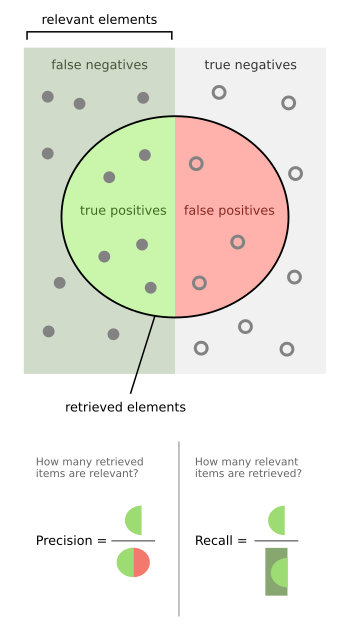

In [27]:
# Calculate recall
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

print("=" * 60)
print("RECALL (SENSITIVITY)")
print("=" * 60)
print(f"\nTraining Recall: {train_recall:.4f}")
print(f"Testing Recall:  {test_recall:.4f}")

print(f"\nInterpretation:")
n_actual_positive = np.sum(y_test == 1)
n_detected_positive = np.sum((y_test == 1) & (y_test_pred == 1))
print(f"  Out of {n_actual_positive} actual Class 1 (high arousal) samples,")
print(f"  we correctly identified {n_detected_positive} of them.")
print(f"  We successfully detected {test_recall*100:.1f}% of all high arousal states.")
print(f"\n  Miss rate (false negatives): {(1-test_recall)*100:.1f}%")

RECALL (SENSITIVITY)

Training Recall: 1.0000
Testing Recall:  0.9434

Interpretation:
  Out of 53 actual Class 1 (high arousal) samples,
  we correctly identified 50 of them.
  We successfully detected 94.3% of all high arousal states.

  Miss rate (false negatives): 5.7%


### 4.5 The Precision-Recall Trade-off

There's often a trade-off between precision and recall. By adjusting the classification threshold (default is 0.5), we can favor one over the other:

- **Lower threshold** (e.g., 0.3): More samples predicted as positive → Higher recall, lower precision
- **Higher threshold** (e.g., 0.7): Fewer samples predicted as positive → Higher precision, lower recall

Let's visualize this trade-off:

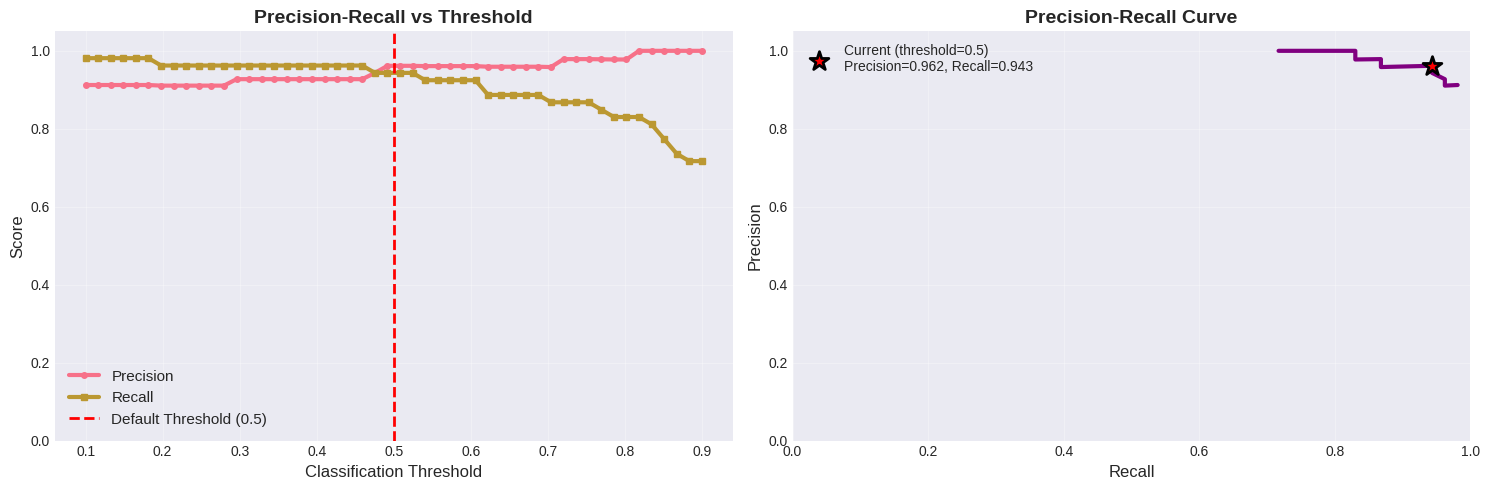

Understanding the Trade-off:
  - As threshold increases → Precision tends to increase, Recall tends to decrease
  - As threshold decreases → Recall tends to increase, Precision tends to decrease
  - The optimal threshold depends on your application's priorities


In [30]:
# Calculate metrics at different thresholds
thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_thresh = (y_test_pred_proba >= threshold).astype(int)
    if np.sum(y_pred_thresh) > 0:  # Avoid division by zero
        precisions.append(precision_score(y_test, y_pred_thresh))
        recalls.append(recall_score(y_test, y_pred_thresh))
    else:
        precisions.append(1.0)  # No predictions, so precision is undefined (set to 1)
        recalls.append(0.0)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Precision and Recall vs Threshold
axes[0].plot(thresholds, precisions, label='Precision', linewidth=3, marker='o', markersize=4)
axes[0].plot(thresholds, recalls, label='Recall', linewidth=3, marker='s', markersize=4)
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Default Threshold (0.5)', linewidth=2)
axes[0].set_xlabel('Classification Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Precision-Recall vs Threshold', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Plot 2: Precision-Recall Curve
axes[1].plot(recalls, precisions, linewidth=3, color='purple')
axes[1].scatter(test_recall, test_precision, s=200, c='red', marker='*',
               edgecolors='black', linewidth=2, zorder=5,
               label=f'Current (threshold=0.5)\nPrecision={test_precision:.3f}, Recall={test_recall:.3f}')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("Understanding the Trade-off:")
print("  - As threshold increases → Precision tends to increase, Recall tends to decrease")
print("  - As threshold decreases → Recall tends to increase, Precision tends to decrease")
print("  - The optimal threshold depends on your application's priorities")

### 4.6 F1-Score

The **F1-Score** is the harmonic mean of precision and recall. It provides a single score that balances both metrics:

$$F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}$$

**Why harmonic mean?** The harmonic mean penalizes extreme values. If either precision or recall is very low, the F1-score will be low, even if the other is high.

**When to use it**: When you want to balance precision and recall, or when you have imbalanced classes.


In [32]:
# Calculate F1-score
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("=" * 60)
print("F1-SCORE")
print("=" * 60)
print(f"\nTraining F1-Score: {train_f1:.4f}")
print(f"Testing F1-Score:  {test_f1:.4f}")

print(f"\nComponent Metrics:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

print(f"\nInterpretation:")
print(f"  F1-score of {test_f1:.3f} indicates a {'good' if test_f1 > 0.8 else 'reasonable' if test_f1 > 0.6 else 'poor'} balance between precision and recall.")
if abs(test_precision - test_recall) > 0.1:
    if test_precision > test_recall:
        print(f"  Note: Precision is higher than recall, suggesting the model is conservative.")
    else:
        print(f"  Note: Recall is higher than precision, suggesting the model is liberal in predictions.")
else:
    print(f"  Precision and recall are well-balanced.")


F1-SCORE

Training F1-Score: 1.0000
Testing F1-Score:  0.9524

Component Metrics:
  Precision: 0.9615
  Recall:    0.9434
  F1-Score:  0.9524

Interpretation:
  F1-score of 0.952 indicates a good balance between precision and recall.
  Precision and recall are well-balanced.


---

## Mini-Project: DEAP Dataset Arousal Classification

### Project Overview

Now it's time to apply everything you've learned to a real EEG dataset! You will work with the **DEAP** dataset to build a classifier that predicts arousal levels.

### Dataset Information

The DEAP dataset contains EEG recordings from 32 participants who watched 40 music videos. After each video, participants rated their emotional state on several dimensions, including **arousal** (calm vs. excited) on a scale from 1 to 9.

For this project:
- **Input features**: Power spectral density (PSD) values in five frequency bands (delta, theta, alpha, beta, gamma) for each of 32 EEG channels
- **Target variable**: Binary arousal level
  - High arousal: rating ≥ 5
  - Low arousal: rating < 5

### Your Tasks

Complete the following steps to build and evaluate your arousal classifier:

#### Task 1: Data Loading and Exploration
1. Load the DEAP dataset (preprocessed data)
2. Extract band power features from the EEG data
3. Create binary arousal labels based on the ratings
4. Visualize the distribution of features and labels
5. Check for class imbalance

#### Task 2: Model Training and Optimization
1. Split the data into training and testing sets (80-20 split)
2. Standardize the features
3. Train a logistic regression model
4. Experiment with different classification thresholds
5. Identify the most important features for arousal classification

#### Task 3: Comprehensive Evaluation
1. Calculate all classification metrics: accuracy, precision, recall, F1-score
2. Create visualizations:
   - Confusion matrix
   - Precision-recall curve
   - Feature importance plot
3. Compare model performance at different thresholds
4. Write a brief interpretation of your results (4-5 sentences)
